# Pengerjaan Tugas Deep Learning menggunakan TensorFlow (Week 7, Dataset DeteksiSarkasme)

File ini memuat pelatihan model Bidirectional RNN dan Deep RNN, masing-masing menggunakan TensorFlow, untuk dataset DeteksiSarkasme.json

# Persiapan: Instalasi library dan Data Preprocessing

### 1. Memastikan Instalasi library

In [167]:
# !pip install numpy matplotlib scikit-learn torch tensorflow tensorflow-datasets
# %pip install numpy matplotlib scikit-learn torch tensorflow[] nltk 

### 2. Mengimpor Library yang Dibutuhkan

In [168]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import SimpleRNN, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import json
import re
import string
import time
from copy import deepcopy

# Memeriksa apakah GPU tersedia dan dapat digunakan oleh TensorFlow
gpu_available = tf.test.is_gpu_available()
print(f"GPU available: {gpu_available}")


GPU available: True


I0000 00:00:1745166635.089574    7949 gpu_device.cc:2019] Created device /device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


### 3. Mendefinisikan Parameter dan Pre-processing Dataset

In [169]:
# Konstanta dan parameter
NUM_WORDS = 40000
MAXLEN = 30
BATCH_SIZE = 16
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
DROPOUT_RATE = 0.5
OUTPUT_DIM = 1
EPOCHS = 25
LEARNING_RATE = 0.0001

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
# Inisialisasi lemmatizer
lemmatizer = WordNetLemmatizer()
# Inisialisasi stopwords
stop_words = set(stopwords.words('english'))

# Baca file JSON yang tidak terformat
input_file = "../DeteksiSarkasme.json"
json_data = []

with open(input_file, "r") as file:
    data = file.read()

# Tampilkan cuplikan dari data JSON yang tidak terformat
print("Cuplikan data JSON yang tidak terformat:")
print(data[:500])  # Menampilkan 500 karakter pertama untuk cuplikan

# Tambahkan koma di antara objek JSON
formatted_data = "[" + data.replace("}\n{", "},\n{") + "]"

# Tampilkan cuplikan dari data JSON yang sudah diformat
print("\nCuplikan data JSON yang sudah diformat:")
print(formatted_data[:500])  # Menampilkan 500 karakter pertama untuk cuplikan

# Parse ulang untuk memastikan validitas JSON
try:
    json_data = json.loads(formatted_data)
    print("\nData JSON berhasil diformat.")

except json.JSONDecodeError as e:
    print(f"Terjadi kesalahan saat memformat JSON: {e}")

# Convert to DataFrame
df = pd.DataFrame(json_data)

# Check class distribution
print("Class distribution:")
print(df['is_sarcastic'].value_counts())
print("\nPercentage:")
print(df['is_sarcastic'].value_counts(normalize=True) * 100)

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Pertahankan tanda baca yang berpotensi penting untuk sarkasme
    text = re.sub(r'[^\w\s\'\"!?.,]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Filter stopwords secara selektif (pertahankan kata-kata penting)
    custom_stopwords = set(stopwords.words('english')) - {'not', 'no', 'very', 'too', 'only', 'just'}
    tokens = [word for word in tokens if word not in custom_stopwords]

    return ' '.join(tokens)

# Apply preprocessing to headlines
df['processed_headline'] = df['headline'].apply(preprocess_text)
print("\nProcessed headlines:")
print(df['processed_headline'].head())

# Extract additional words from the website links
df['additional_words'] = df['article_link'].apply(
    lambda x: re.findall(r'\w+', x.split('/')[-1]) if '/' in x else []
).apply(lambda x: [word for word in x if word not in ['html', 'htm'] and len(word) > 1])
df['additional_words'] = df['additional_words'].apply(
    lambda x: x[:-1] + x[-1].split('_')[:-1] if x and len(x[-1].split('_')) > 1 else x
)
df['additional_words'] = df['additional_words'].apply(
    lambda x: x[:-1] if x and len(x[-1]) < 3 else x
)
print(df['additional_words'])

# Combine processed headline and additional words
df['processed_headline'] = ' ' + df['additional_words'].apply(' '.join) + ' ' + df['processed_headline']
print("\nCombined processed headlines:")
print(df['processed_headline'].head())

# Check for null values
print("\nChecking for null values:")
print(df.isnull().sum())

# Drop rows with null values
df.dropna(inplace=True)
print("\nAfter dropping null values:")
print(df.isnull().sum())

# Split data
X = df['processed_headline'].values
y = df['is_sarcastic'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Tokenization and padding for deep learning models
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Pad sequences for uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=MAXLEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAXLEN, padding='post')

# Untuk TensorFlow
train_data = (X_train_pad, y_train)
test_data = (X_test_pad, y_test)

[nltk_data] Downloading package punkt to /home/husain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/husain/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/husain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/husain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cuplikan data JSON yang tidak terformat:
{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret 'black code' for minority shoppers", "is_sarcastic": 0}
{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "is_sarcastic": 0}
{"article_link": "https://local.theonion.com/mom-starti

Cuplikan data JSON yang sudah diformat:
[{"article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5", "headline": "former versace store clerk sues over secret 'black code' for minority shoppers", "is_sarcastic": 0},
{"article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365", "headline": "the 'roseanne' revival catches up to our thorny political mood, for better a

### 4. Menyiapkan Fungsi Pelatihan dan Validasi

In [170]:
# Fungsi untuk melatih model TensorFlow
def train_model_tf(model, train_data, model_name):
    x_train, y_train = train_data
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=f'model_tensorflow_{model_name}.keras',
            monitor='val_loss',
            save_best_only=True
        )
    ]
    
    print(f"Memulai pelatihan model {model_name}...")
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        x_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        shuffle=True,
        callbacks=callbacks,
        verbose=1
    )
    
    end_time = time.time()
    training_time = end_time - start_time
    mins, secs = divmod(training_time, 60)
    print(f"Waktu pelatihan: {int(mins)}m {int(secs)}s")
    
    return history

### 5. Menyiapkan Fungsi Evaluasi

In [171]:
# Fungsi untuk evaluasi model TensorFlow
def evaluate_model_tf(model, test_data, model_name):
    x_test, y_test = test_data
    
    # Prediksi
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # Menghitung ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    # Print hasil evaluasi
    print(f"\nEvaluasi Model {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred_prob': y_pred_prob,
        'y_pred': y_pred,
        'y_test': y_test
    }

### 6. Menyiapkan Fungsi Visualisasi

In [ ]:
# Fungsi untuk membuat visualisasi hasil
# Fungsi untuk membuat visualisasi training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    best_epoch = history['val_loss'].index(min(history['val_loss']))
    best_val_loss = min(history['val_loss'])

    # Plot Loss, dengan tanda pada titik terbaik
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Valid Loss')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=best_val_loss, color='g', linestyle='--', label='Best Val Loss')
    plt.title(f'{model_name} - Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Valid Accuracy')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=history['val_accuracy'][best_epoch], color='g', linestyle='--', label='Val Accuracy at Best Model')
    plt.title(f'{model_name} - Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'training_history_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat ROC curve
def plot_roc_curve(results_dict):
    plt.figure(figsize=(10, 8))
    
    for model_name, result in results_dict.items():
        plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["auc"]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig('roc_curve_comparison_tensorflow.png')
    plt.show()

# Fungsi untuk membuat bar chart perbandingan metrik
def plot_metrics_comparison(results_dict):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    models = list(results_dict.keys())
    
    values = {metric: [results_dict[model][metric] for model in models] for metric in metrics}
    
    plt.figure(figsize=(12, 8))
    bar_width = 0.15
    index = np.arange(len(models))
    
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, values[metric], bar_width, 
                label=metric.capitalize())
    
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Performance Metrics Comparison')
    plt.xticks(index + bar_width * 2, models)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('metrics_comparison_tensorflow.png')
    plt.show()


## A. Model Bidirectional RNN Menggunakan TensorFlow

### 1. Menyusun Model Bidirectional RNN


In [173]:
# Fungsi untuk membuat model RNN kompleks
def build_birnn_model():
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, EMBEDDING_DIM),
        
        Bidirectional(SimpleRNN(HIDDEN_DIM, return_sequences=True)),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        Bidirectional(SimpleRNN(HIDDEN_DIM, return_sequences=False)),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        
        Dense(HIDDEN_DIM // 2, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# inisialisasi model
model_birnn = build_birnn_model()

### 2. Melatih Model

In [174]:
# Menyusun model
model_birnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model RNN
print("Melatih model RNN...")
history_birnn = train_model_tf(model_birnn, (X_train_pad, y_train), 'birnn')

Melatih model RNN...
Memulai pelatihan model birnn...
Epoch 1/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.6006 - loss: 0.9109 - val_accuracy: 0.7960 - val_loss: 0.5042
Epoch 2/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.7687 - loss: 0.5563 - val_accuracy: 0.8496 - val_loss: 0.4321
Epoch 3/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.8942 - loss: 0.3187 - val_accuracy: 0.8566 - val_loss: 0.4392
Epoch 4/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.9424 - loss: 0.1856 - val_accuracy: 0.8545 - val_loss: 0.5438
Epoch 5/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.9664 - loss: 0.1326 - val_accuracy: 0.8687 - val_loss: 0.5215
Epoch 6/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.9819 - loss: 0.0831 - val_accuracy: 0.8615 - val_loss: 0.6486
Epoch 7/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.9852 - loss: 0.0638 - val_accuracy: 0.8680 - val_loss: 0.6552
Waktu pelatihan: 3m 20

### 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [175]:
# Evaluasi model RNN
result_birnn = evaluate_model_tf(model_birnn, test_data, 'birnn')

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Evaluasi Model birnn:
Accuracy: 0.8532
Precision: 0.8398
Recall: 0.8226
F1 Score: 0.8311
AUC: 0.9221


### 4. Memvisualisasikan Prediksi dari model yang telah dilatih

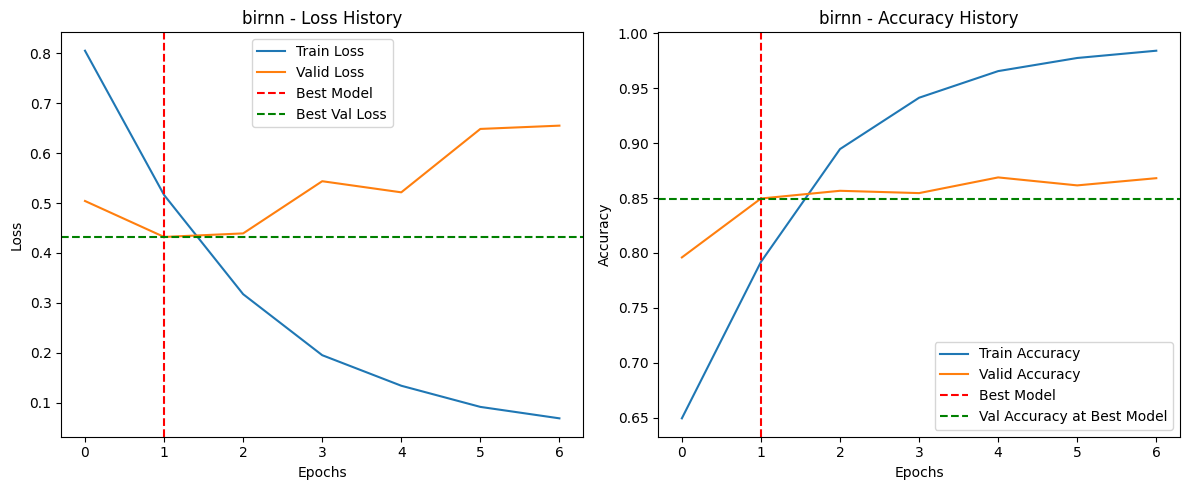

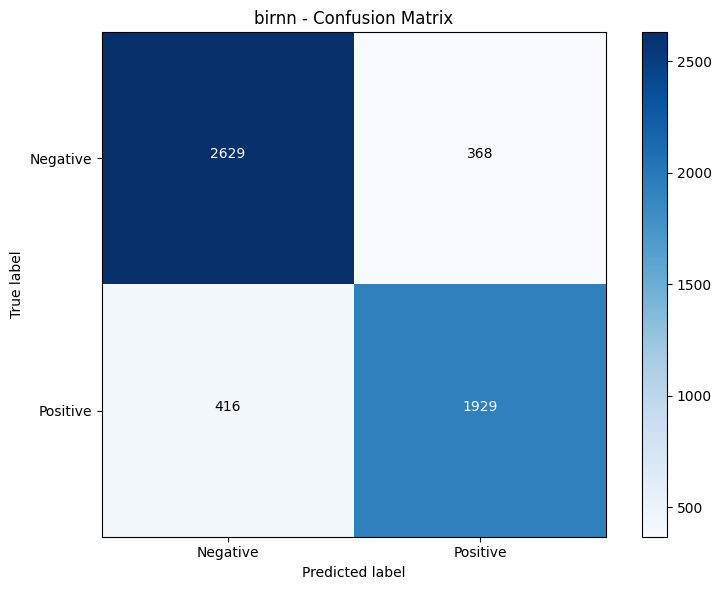

In [176]:
# Plotting hasil pelatihan
plot_training_history(history_birnn.history, "birnn")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_birnn['y_pred'], "birnn")

### 5. Menyimpan Model

In [177]:
# Menyimpan model
model_birnn.save('model_tensorflow_birnn.keras')
print("Model RNN disimpan sebagai 'model_tensorflow_birnn.keras'")

Model RNN disimpan sebagai 'model_tensorflow_birnn.keras'


## B. Model Deep RNN Menggunakan TensorFlow

### 1. Menyusun Model Deep RNN


In [178]:
# Fungsi untuk membuat model RNN kompleks
def build_drnn_model():
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, EMBEDDING_DIM),
        
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        SimpleRNN(HIDDEN_DIM, return_sequences=False),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        
        Dense(HIDDEN_DIM, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(HIDDEN_DIM // 2, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(HIDDEN_DIM // 4, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])
    
    return model

# inisialisasi model
model_drnn = build_birnn_model()

### 2. Melatih Model

In [179]:
# Menyusun model
model_drnn.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Melatih model RNN
print("Melatih model RNN...")
history_drnn = train_model_tf(model_drnn, (X_train_pad, y_train), 'drnn')

Melatih model RNN...
Memulai pelatihan model drnn...
Epoch 1/25
 797/1069 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5831 - loss: 0.9741

1069/1069 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - accuracy: 0.5985 - loss: 0.9417 - val_accuracy: 0.8196 - val_loss: 0.4857
Epoch 2/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.7779 - loss: 0.5706 - val_accuracy: 0.8362 - val_loss: 0.4068
Epoch 3/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.8873 - loss: 0.3303 - val_accuracy: 0.8680 - val_loss: 0.4839
Epoch 4/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.9365 - loss: 0.2083 - val_accuracy: 0.8650 - val_loss: 0.4342
Epoch 5/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.9621 - loss: 0.1336 - val_accuracy: 0.8690 - val_loss: 0.5047
Epoch 6/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.9773 - loss: 0.0903 - val_accuracy: 0.8694 - val_loss: 0.5363
Epoch 7/25
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.9858 - loss: 0.0626 - val_accuracy: 0.8652 - val_loss: 0.5475
Waktu pelatihan: 3m 8s


### 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [180]:
# Evaluasi model RNN
result_drnn = evaluate_model_tf(model_drnn, test_data, 'drnn')

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Evaluasi Model drnn:
Accuracy: 0.8454
Precision: 0.7882
Recall: 0.8857
F1 Score: 0.8341
AUC: 0.9248


### 4. Memvisualisasikan Prediksi dari model yang telah dilatih

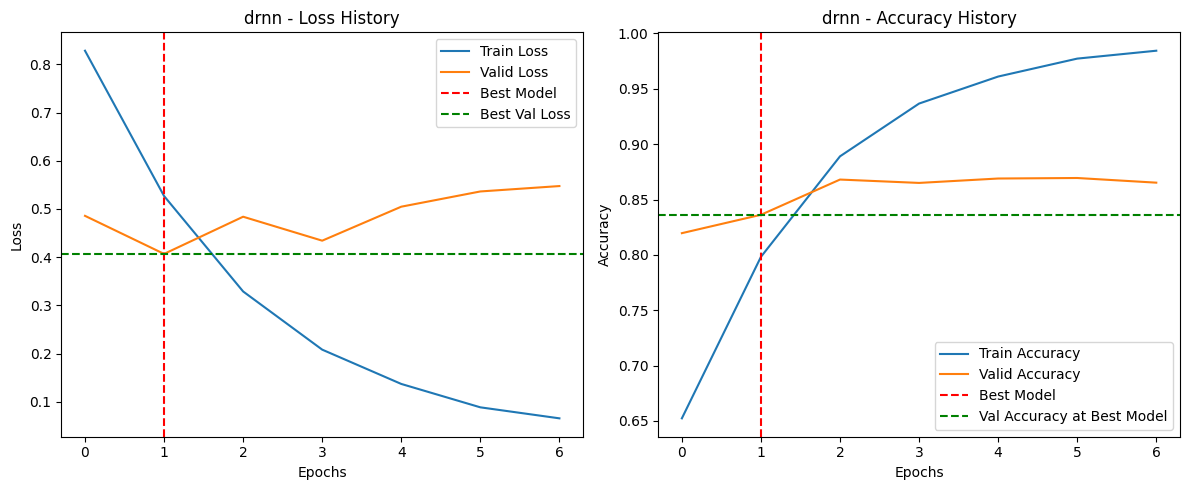

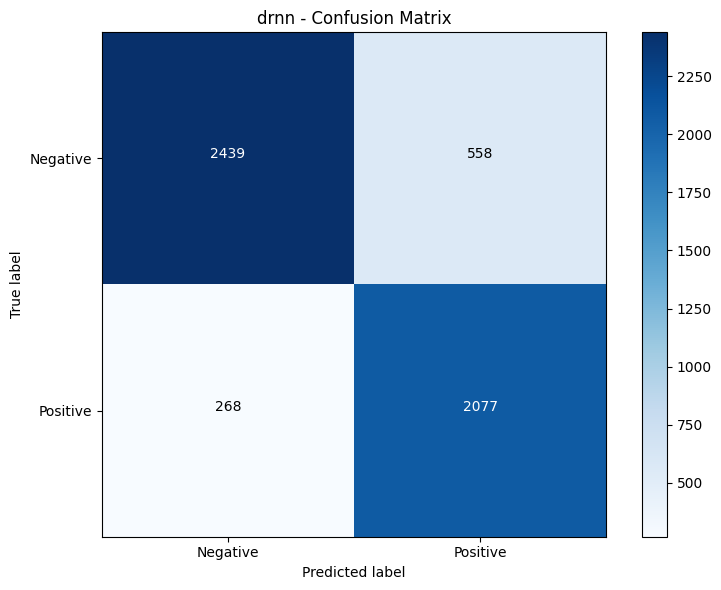

In [181]:
# Plotting hasil pelatihan
plot_training_history(history_drnn.history, "drnn")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_drnn['y_pred'], "drnn")

### 5. Menyimpan Model

In [182]:
# Menyimpan model
model_birnn.save('model_tensorflow_drnn.keras')
print("Model RNN disimpan sebagai 'model_tensorflow_drnn.keras'")

Model RNN disimpan sebagai 'model_tensorflow_drnn.keras'


# Perbandingan antara model

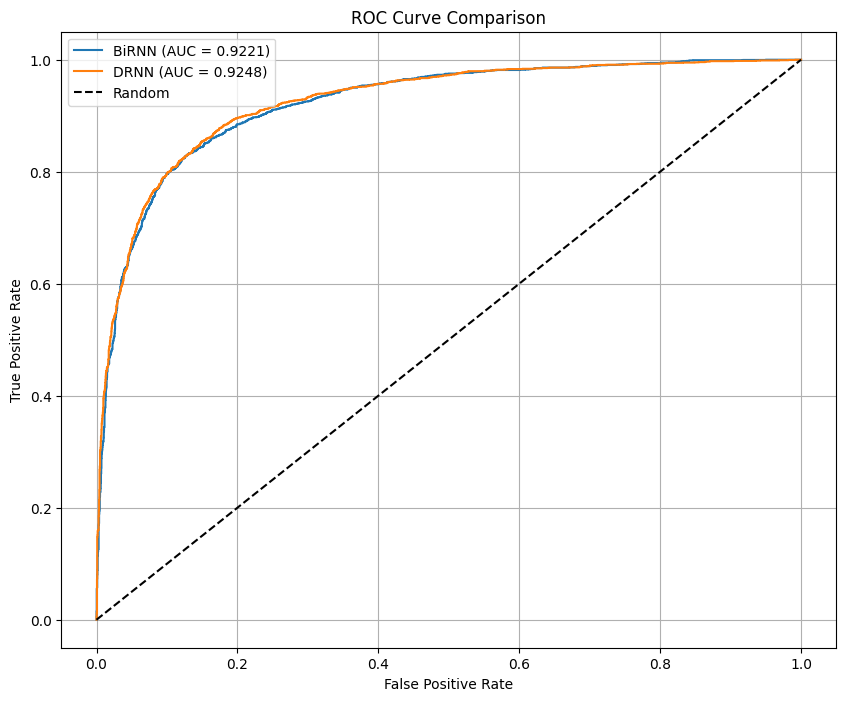

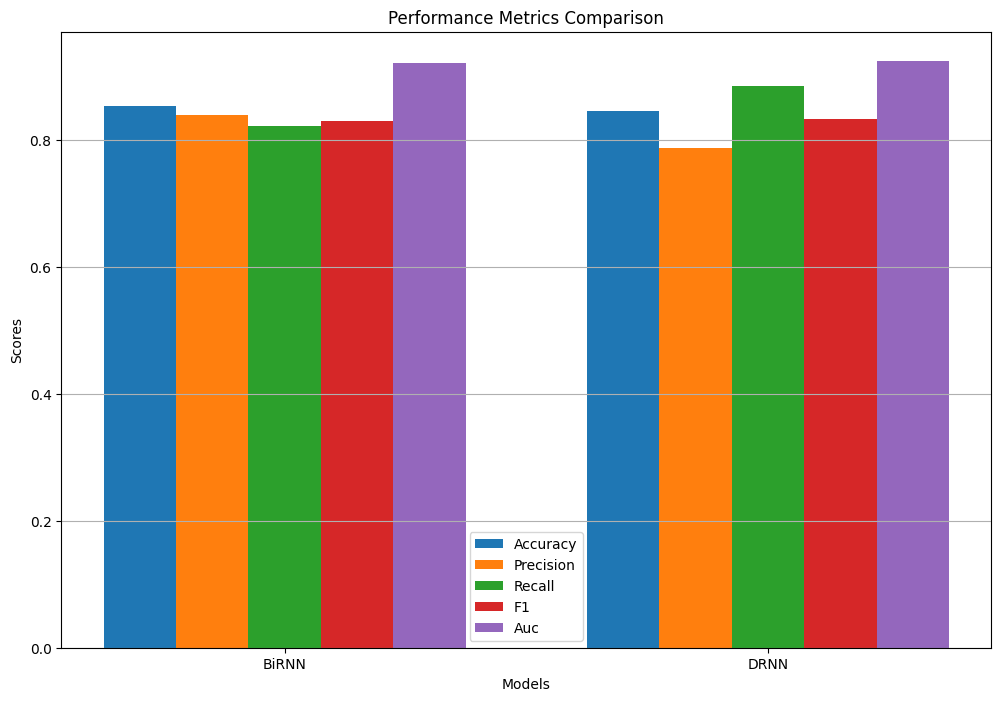

In [183]:
# Menghitung perbandingan untuk semua model
results_dict = {
    'BiRNN': result_birnn,
    'DRNN': result_drnn,
}

# Plotting ROC curve
plot_roc_curve(results_dict)
# Plotting perbandingan metrik
plot_metrics_comparison(results_dict)